In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
%matplotlib inline

In [71]:
def phi_pol(x, orden):
    pol = []
    for i in orden:
            pol.append(x**int(i))
    return np.array(pol).T


def modelo2(x, pre_params, params):
    m = 0
    for i in range(len(pre_params)):
        m += pre_params[i]*x**(i+1)
    m += params[0]*np.sin(params[1]*x + params[2])*np.exp(params[3]*x)
    return m


def log_like(params, x, y, pre_params, sigma_e):
    mod = modelo2(x, pre_params, params)
    arg = - 0.5*(len(y)*np.log(2*np.pi*sigma_e**2) + np.sum((y - mod)**2))
    return arg


def MAP(x, y, orden, basis='pol', reg=0):
    """
    Retorna:
    t: estimador MAP
    """
    d = len(orden)
    if basis=='pol':
        p = phi_pol(x, orden=orden)
    t = np.linalg.inv(p.T@p + reg*np.ones((d, d)))@p.T@y
    return t


$Y = \Phi(X) \theta + \eta$

$\theta_{\text{MAP}} = (\Phi^{T}(X)\Phi(X))^{-1} \Phi^{T}(X) Y$

$\theta_{\text{MAP}} = (\Phi^{T}(X)\Phi(X) + \rho \mathbb{1})^{-1} \Phi^{T}(X) Y$

$\Phi(X) \in N \text{x} D$

$\rho = \frac{\sigma_{\epsilon}^{2}}{\sigma_{\theta}^{2}}$

Donde $\sigma_{\theta}^{2}$ es la varianza del prior y $\sigma_{\epsilon}^{2}$ es el error de medición. Suponiendo que $\sigma_{\epsilon}^{2} = 1$:

$\rho = \frac{1}{\sigma_{\theta}^{2}}$

Text(0.5,1,'conjunto de datos')

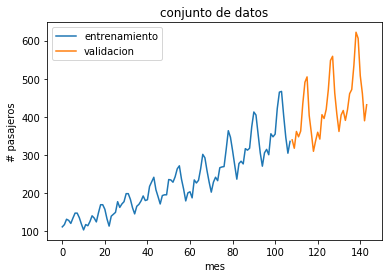

In [5]:
data = np.loadtxt('datosT2.txt')
n_train = int(12*9)
mes_train = data[:n_train, 0]
pax_train = data[:n_train, 1]
mes_val = data[n_train:, 0]
pax_val = data[n_train:, 1]
plt.plot(mes_train, pax_train, label='entrenamiento')
plt.plot(mes_val, pax_val, label='validacion')
plt.legend()
plt.xlabel('mes')
plt.ylabel('# pasajeros')
plt.title('conjunto de datos')

In [34]:
s_e = 1
rho = 1
s_t = 1

theta_map = MAP(mes_train, pax_train, orden=np.arange(1, 5, 1), basis='pol', reg=rho)
print('theta_map =', theta_map)

theta_map = [ 1.47722714e+01 -4.29954151e-01  5.46826476e-03 -2.28112509e-05]


In [7]:
p_train = phi_pol(mes_train, orden=np.arange(1, 5, 1))
p_val = phi_pol(mes_val, orden=np.arange(1, 5, 1))
y_train = p_train@theta_map
y_val = p_val@theta_map

Text(0.5,1,'conjunto de datos')

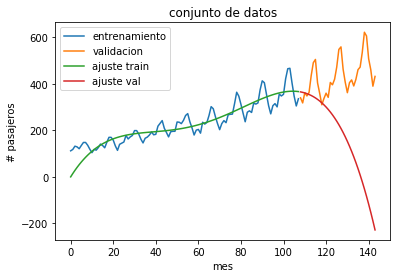

In [8]:
data = np.loadtxt('datosT2.txt')
n_train = int(12*9)
mes_train = data[:n_train, 0]
pax_train = data[:n_train, 1]
mes_val = data[n_train:, 0]
pax_val = data[n_train:, 1]
plt.plot(mes_train, pax_train, label='entrenamiento')
plt.plot(mes_val, pax_val, label='validacion')
plt.plot(mes_train, y_train, label='ajuste train')
plt.plot(mes_val, y_val, label='ajuste val')
plt.legend()
plt.xlabel('mes')
plt.ylabel('# pasajeros')
plt.title('conjunto de datos')

verosimilitud -94184.38015231535


Text(0,0.5,'pax')

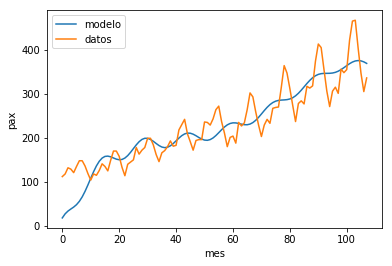

In [74]:
L = log_like(params=[20, 2*3.14/15,2,-0.01], x=mes_train, y=pax_train, pre_params=theta_map, sigma_e=s_e)

print('verosimilitud', L)

plt.plot(mes_train, m2, label='modelo')
plt.plot(mes_train, pax_train, label='datos')
plt.legend()
plt.xlabel('mes')
plt.ylabel('pax')

In [77]:
res = minimize(fun=log_like, x0=np.array([0, 0, 0, 0.01]), args=(mes_train, pax_train, theta_map, s_e), method='BFGS')
print(res)

      fun: -91767.9783358168
 hess_inv: array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])
      jac: array([0., 0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 6
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.  , 0.  , 0.  , 0.01])


In [69]:
def model(a, x):
    return a[0]**2*x**2 + a[1]**2*x**2

X = np.arange(-1, 1, 100)

res = minimize(fun=model, x0=np.array([5, 5]), args=(X), method='BFGS')

print(res)

      fun: 4.507538778807646e-14
 hess_inv: array([[ 0.75000001, -0.24999999],
       [-0.24999999,  0.75000001]])
      jac: array([-2.85350026e-07, -2.85350026e-07])
  message: 'Optimization terminated successfully.'
     nfev: 16
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([-1.50125594e-07, -1.50125594e-07])
